## MODEL OPTIMIZATION AND VALIDATION 

In [81]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

In [82]:
# Load the dataset
df = pd.read_csv('credit.csv')

## PREPROCESSING 

In [83]:
# List of unwanted features
unwanted_features = ['ID', 'Customer_ID', 'Name', 'Age', 'SSN', 'Type_of_Loan', 'Num_Credit_Inquiries']

In [84]:
# Drop unwanted features
df = df.drop(unwanted_features, axis=1)

In [85]:
# Normalize numerical features
scaler = StandardScaler()
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

In [86]:
# Find the number of outliers in each numerical column
numerical_cols = ['Month','Annual_Income','Monthly_Inhand_Salary','Num_Bank_Accounts','Num_Credit_Card','Interest_Rate',
                  'Delay_from_due_date','Num_of_Delayed_Payment','Num_of_Loan','Changed_Credit_Limit',
                  'Credit_Utilization_Ratio','Outstanding_Debt','Credit_History_Age',
                  'Total_EMI_per_month', 'Amount_invested_monthly']

In [87]:
num_outliers = []
for col in numerical_cols:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lower_limit = q1 - 1.5 * iqr
    upper_limit = q3 + 1.5 * iqr
    outliers = df[(df[col] < lower_limit) | (df[col] > upper_limit)].shape[0]
    num_outliers.append(outliers)

print("Number of outliers in each column:")
for i, col in enumerate(numerical_cols):
    print(f"{col}: {num_outliers[i]} outliers detected")

Number of outliers in each column:
Month: 0 outliers detected
Annual_Income: 2000 outliers detected
Monthly_Inhand_Salary: 2017 outliers detected
Num_Bank_Accounts: 0 outliers detected
Num_Credit_Card: 0 outliers detected
Interest_Rate: 0 outliers detected
Delay_from_due_date: 4002 outliers detected
Num_of_Delayed_Payment: 0 outliers detected
Num_of_Loan: 0 outliers detected
Changed_Credit_Limit: 579 outliers detected
Credit_Utilization_Ratio: 4 outliers detected
Outstanding_Debt: 5272 outliers detected
Credit_History_Age: 0 outliers detected
Total_EMI_per_month: 5044 outliers detected
Amount_invested_monthly: 4464 outliers detected


In [88]:
# Cap outlier values
# Calculate the upper and lower limits for outlier capping
upper_limits = {}
lower_limits = {}
for col in numerical_cols:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    upper_limits[col] = q3 + 1.5 * iqr
    lower_limits[col] = q1 - 1.5 * iqr

# Cap outlier values
for col in numerical_cols:
    df[col] = np.where(df[col] > upper_limits[col], upper_limits[col], df[col])
    df[col] = np.where(df[col] < lower_limits[col], lower_limits[col], df[col])

In [89]:
# Display the remaining outliers after processing
print("\nOutliers after processing:")
num_outliers = []
for col in numerical_cols:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lower_limit = q1 - 1.5 * iqr
    upper_limit = q3 + 1.5 * iqr
    outliers = df[(df[col] < lower_limit) | (df[col] > upper_limit)].shape[0]
    num_outliers.append(outliers)

print("Number of outliers in each column:")
for i, col in enumerate(numerical_cols):
    print(f"{col}: {num_outliers[i]} outliers detected")


Outliers after processing:
Number of outliers in each column:
Month: 0 outliers detected
Annual_Income: 0 outliers detected
Monthly_Inhand_Salary: 0 outliers detected
Num_Bank_Accounts: 0 outliers detected
Num_Credit_Card: 0 outliers detected
Interest_Rate: 0 outliers detected
Delay_from_due_date: 0 outliers detected
Num_of_Delayed_Payment: 0 outliers detected
Num_of_Loan: 0 outliers detected
Changed_Credit_Limit: 0 outliers detected
Credit_Utilization_Ratio: 0 outliers detected
Outstanding_Debt: 0 outliers detected
Credit_History_Age: 0 outliers detected
Total_EMI_per_month: 0 outliers detected
Amount_invested_monthly: 0 outliers detected


In [90]:
# One-hot encoding
categorical_cols = ['Occupation','Delay_from_due_date', 'Num_of_Delayed_Payment',
                    'Credit_Mix','Payment_Behaviour','Payment_of_Min_Amount']

In [91]:
df = pd.get_dummies(df, columns=categorical_cols)

In [92]:
# Label Encoding
target_column = 'Credit_Score'
label_encoder = LabelEncoder()
df[target_column] = label_encoder.fit_transform(df[target_column])
labels_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Encoding:")
for label, code in labels_mapping.items():
    print(f"{label}: {code}")

Label Encoding:
Good: 0
Poor: 1
Standard: 2


## Random Forest Classifier model

In [93]:
# Split the data into training, validation, and testing sets
X_train_val, X_test, y_train_val, y_test = train_test_split(df.drop('Credit_Score', axis=1), 
                                                            df['Credit_Score'], 
                                                            test_size=0.2, 
                                                            random_state=42)

In [94]:
# Further split training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, 
                                                  test_size=0.2,  # 0.25 * 0.8 = 0.2
                                                  random_state=42)  # Using the same random state for consistency

In [95]:
# MODEL TRAINING

# Initialize the RandomForestClassifier model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

In [96]:
# Fit the RandomForestClassifier model to the training data
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [97]:
# MODEL EVALUATION

# Predict the target variable for validation set
y_val_pred = rf_model.predict(X_val)

In [98]:
# Evaluate the model using accuracy on validation set
accuracy_val = accuracy_score(y_val, y_val_pred)
print("\nValidation Set Accuracy: {:.2f}%".format(accuracy_val * 100))


Validation Set Accuracy: 80.90%


In [99]:
# Predict the target variable for the test set
y_test_pred = rf_model.predict(X_test)

In [100]:
# Evaluate the model using accuracy on test set
accuracy_test = accuracy_score(y_test, y_test_pred)
print("\nTest Set Accuracy: {:.2f}%".format(accuracy_test * 100))


Test Set Accuracy: 81.12%


## Hyperparameter Tuning

## RandomizedSearchCV

In [101]:
# Split the data into training, validation, and testing sets
X_train_val, X_test, y_train_val, y_test = train_test_split(df.drop('Credit_Score', axis=1), 
                                                            df['Credit_Score'], 
                                                            test_size=0.1, 
                                                            random_state=42)

In [102]:
# Further split training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, 
                                                  test_size=0.05,  # 0.05 * 0.8 = 0.2
                                                  random_state=42)  # Use the same random state for consistency

In [103]:
# Hyperparameter tuning using RandomizedSearchCV
param_grid = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

In [104]:
# Initialize the RandomForestClassifier
rf_model = RandomForestClassifier(random_state=42)

In [105]:
# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=rf_model, param_distributions=param_grid, n_iter=5,
                                   scoring='accuracy', cv=5, verbose=2, random_state=42, n_jobs=-1)


In [106]:
# Fit RandomizedSearchCV to the training data
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [None, 10, 20, 30],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 100, 150, 200]},
                   random_state=42, scoring='accuracy', verbose=2)

In [107]:
# Print the best parameters found
print("\nBest Parameters:", random_search.best_params_)


Best Parameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': None, 'bootstrap': False}


In [108]:
# Retrieve the best model found
best_model = random_search.best_estimator_

In [109]:
# Predict the target variable for validation set
y_val_pred = best_model.predict(X_val)

In [110]:
# Evaluate the model using accuracy on validation set
accuracy_val = accuracy_score(y_val, y_val_pred)
print("\nValidation Set Accuracy: {:.2f}%".format(accuracy_val * 100))


Validation Set Accuracy: 83.20%


In [111]:
# Predict the target variable for the test set
y_test_pred = best_model.predict(X_test)

In [112]:
# Evaluate the model using accuracy on test set
accuracy_test = accuracy_score(y_test, y_test_pred)
print("\nTest Set Accuracy: {:.2f}%".format(accuracy_test * 100))


Test Set Accuracy: 82.70%


## Cross-Validation

In [113]:
# Define the RandomForestClassifier model with the best parameters
best_rf_model = RandomForestClassifier(n_estimators=random_search.best_params_['n_estimators'],
                                       max_depth=random_search.best_params_['max_depth'],
                                       min_samples_split=random_search.best_params_['min_samples_split'],
                                       min_samples_leaf=random_search.best_params_['min_samples_leaf'],
                                       bootstrap=random_search.best_params_['bootstrap'],
                                       random_state=42)

In [114]:
# Perform cross-validation on the entire dataset
cv_scores = cross_val_score(best_rf_model, X_train_val, y_train_val, cv=5, scoring='accuracy')

In [115]:
# Print cross-validation scores
print("Cross-Validation Scores:", cv_scores)

Cross-Validation Scores: [0.81794444 0.82022222 0.81727778 0.819      0.82094444]


In [116]:
# Calculate and print the mean accuracy and standard deviation of cross-validation scores
print("Mean Accuracy: {:.2f}%".format(cv_scores.mean() * 100))
print("Standard Deviation of Accuracy: {:.2f}%".format(cv_scores.std() * 100))

Mean Accuracy: 81.91%
Standard Deviation of Accuracy: 0.14%


## Model Interpretability

In [117]:
# Extract feature importances
feature_importances = best_model.feature_importances_

In [118]:
# Create a DataFrame to hold feature names and their importances
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})

In [119]:
# Sort features by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

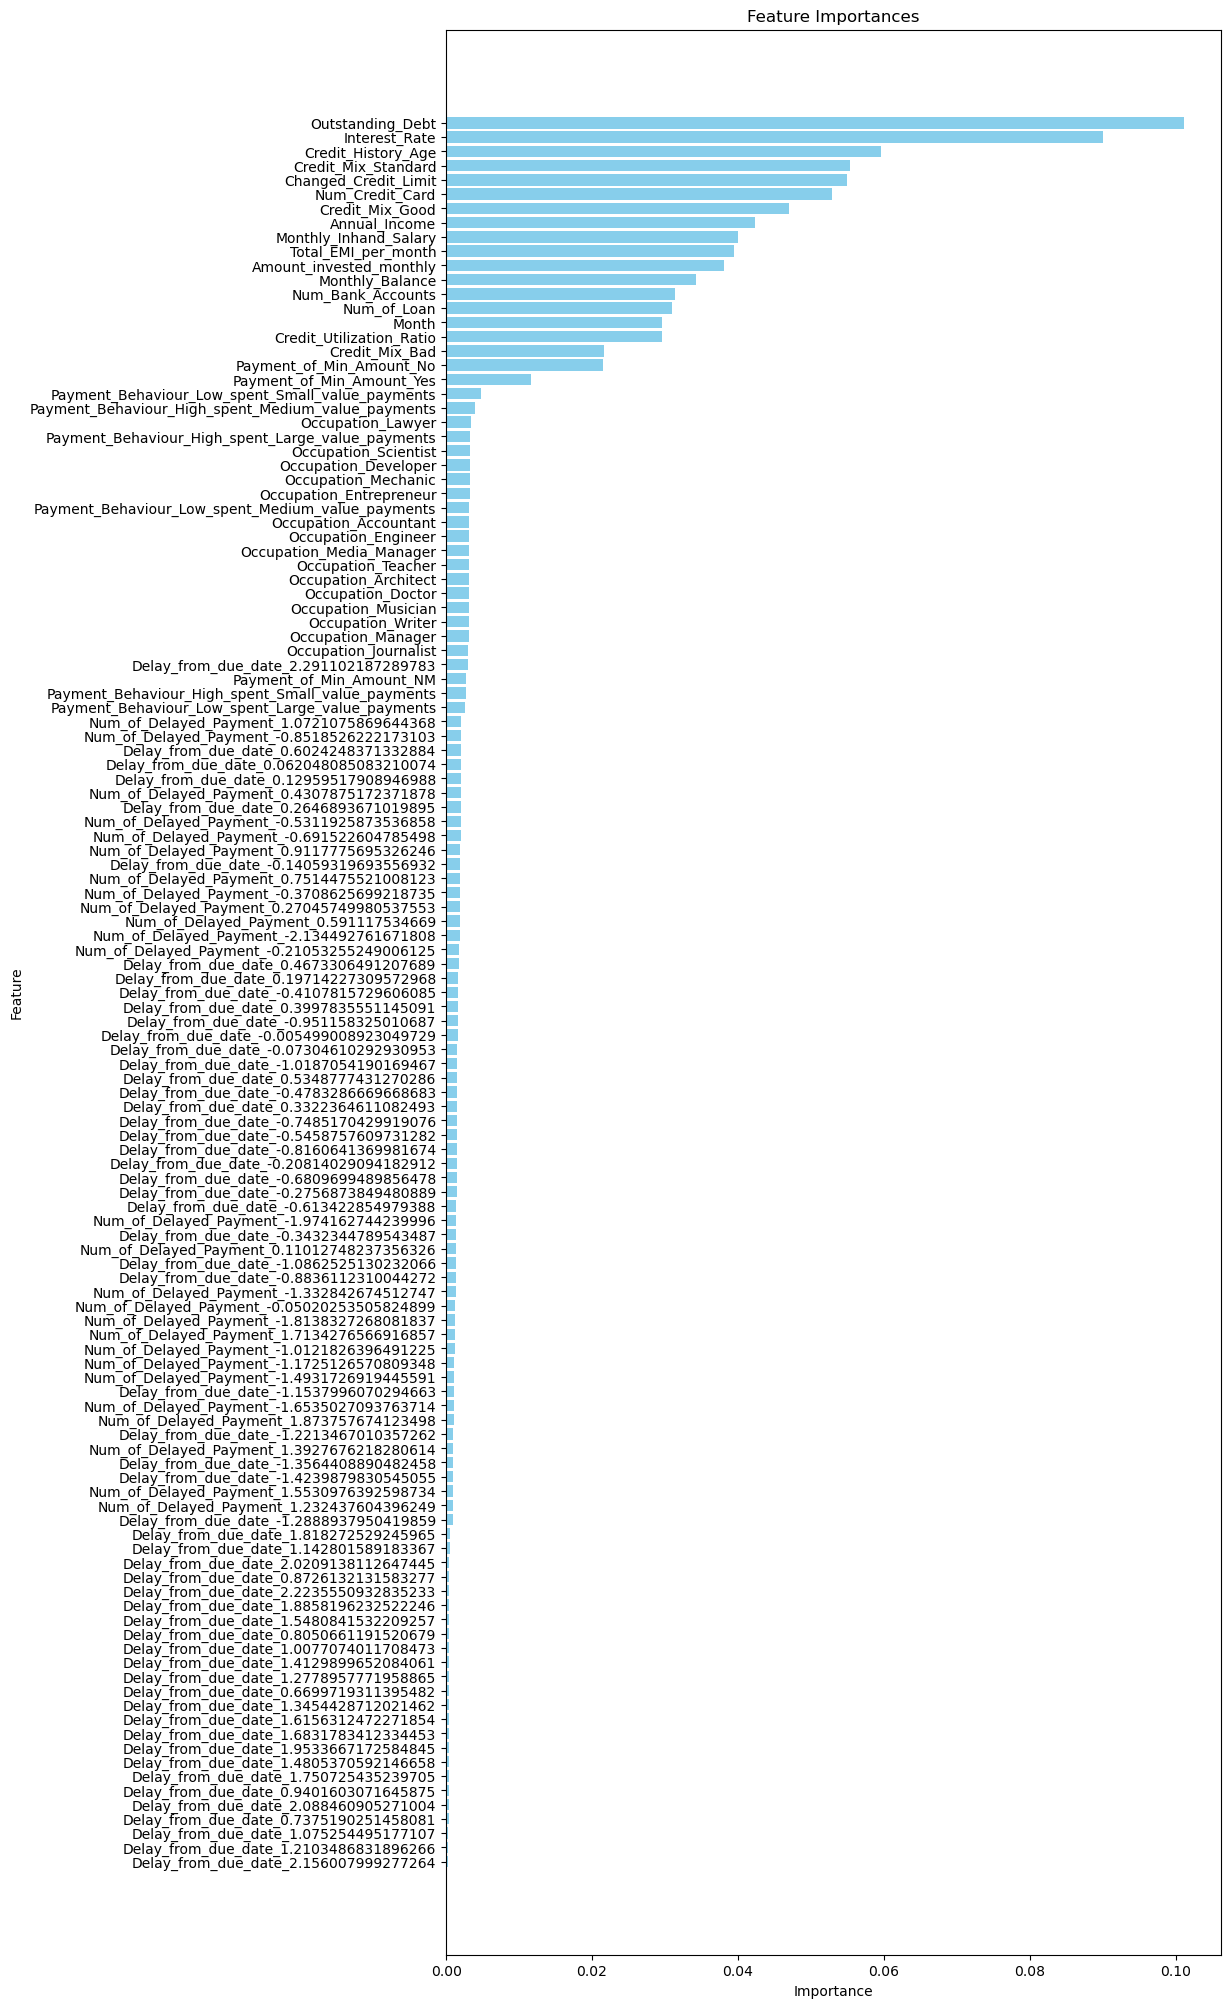

In [120]:
# Plot feature importances
plt.figure(figsize=(10, 25))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature at the top
plt.show()

## Performance Validation

In [121]:
# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_test_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.79      0.79      1777
           1       0.82      0.85      0.83      2979
           2       0.85      0.83      0.84      5244

    accuracy                           0.83     10000
   macro avg       0.82      0.82      0.82     10000
weighted avg       0.83      0.83      0.83     10000



In [122]:
# ROC-AUC Score (One-vs-Rest strategy)
roc_auc = roc_auc_score(y_test, best_model.predict_proba(X_test), multi_class='ovr')
print("ROC-AUC Score:", roc_auc)

ROC-AUC Score: 0.9373648521981434


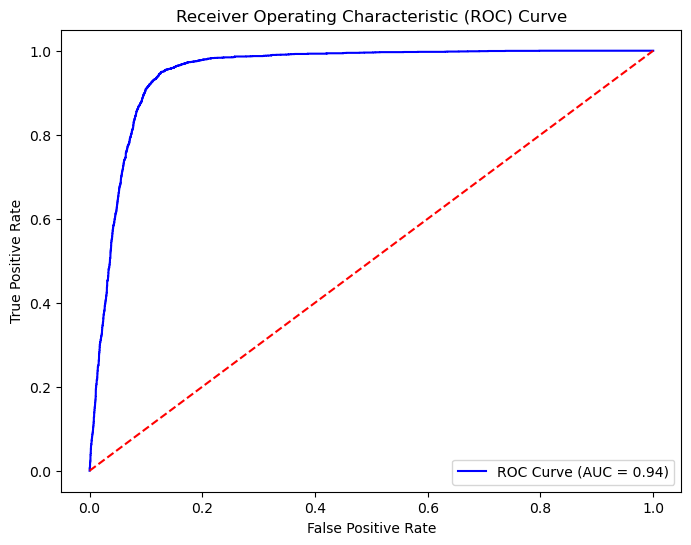

In [123]:
# ROC Curve (One-vs-Rest strategy)
fpr, tpr, _ = roc_curve(y_test, best_model.predict_proba(X_test)[:, 1], pos_label=1)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='ROC Curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

## Threshold Selection:

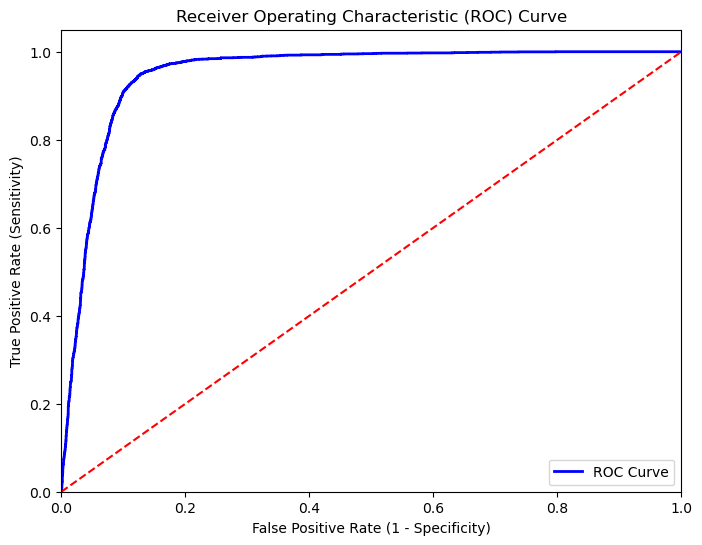

Optimal Threshold: 0.2749805194805195


In [125]:
# Compute ROC curve for each class
fpr, tpr, thresholds = roc_curve(y_test, best_model.predict_proba(X_test)[:, 1], pos_label=1)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC Curve')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Find optimal threshold
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Optimal Threshold:", optimal_threshold)